In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import statsmodels.formula.api as smf
from input.plot_styles import family_colors, set_plot_style, model_order

In [3]:
set_plot_style()

In [4]:
model_dict = {"qwen8":"Qwen/Qwen3-8B",
             "qwen14": "Qwen/Qwen3-14B",
             "gemma12": "google/gemma-3-12b-it",
             "gemma27": "google/gemma-3-27b-it",
             "llama8": "meta-llama/Llama-3.1-8B-Instruct",
             "ministral14": "mistralai/Ministral-3-14B-Instruct-2512",
             "ministral8": "mistralai/Ministral-3-8B-Instruct-2512"}

### Loading Data

In [5]:
def load_results_to_dict(num_mails, subfolder = "both"):
    
    directory = f"results/results_advanced_choice/{num_mails}/{subfolder}"
    
    df_dict = {}
    
    # Check if directory exists
    if not os.path.exists(directory):
        print(f"Directory {directory} not found.")
        return df_dict

    # Iterate through files in the folder
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            # Extract model name from filename (e.g., 'answers_choose5_llama8.csv')
            # split by '_' and use the last part without '.csv'
            model_name = filename.split('_')[-1].replace('.csv', '')
            
            # Load the dataframe
            file_path = os.path.join(directory, filename)
            df_dict[model_name] = pd.read_csv(file_path)
            
            print(f"✓ Loaded {model_name}")
            
    return df_dict


In [6]:
# Loading for not urgent with control
df_dict_2_control = load_results_to_dict(2,"not_urgent")
df_dict_5_control = load_results_to_dict(5, "not_urgent")
df_dict_10_control = load_results_to_dict(10, "not_urgent")

✓ Loaded gemma12
✓ Loaded gemma27
✓ Loaded llama8
✓ Loaded ministral14
✓ Loaded ministral8
✓ Loaded qwen8
✓ Loaded qwen14
✓ Loaded gemma12
✓ Loaded llama8
✓ Loaded gemma27
✓ Loaded ministral14
✓ Loaded ministral8
✓ Loaded qwen14
✓ Loaded qwen8
✓ Loaded gemma12
✓ Loaded llama8
✓ Loaded ministral8
✓ Loaded ministral14
✓ Loaded gemma27
✓ Loaded qwen8
✓ Loaded qwen14


In [7]:
# Loading for not urgent with control
df_dict_2_control_urgent = load_results_to_dict(2,"urgent")
df_dict_5_control_urgent = load_results_to_dict(5, "urgent")
df_dict_10_control_urgent = load_results_to_dict(10, "urgent")

✓ Loaded gemma12
✓ Loaded gemma27
✓ Loaded llama8
✓ Loaded ministral14
✓ Loaded ministral8
✓ Loaded qwen8
✓ Loaded qwen14
✓ Loaded gemma12
✓ Loaded gemma27
✓ Loaded ministral14
✓ Loaded llama8
✓ Loaded ministral8
✓ Loaded qwen8
✓ Loaded qwen14
✓ Loaded gemma12
✓ Loaded gemma27
✓ Loaded ministral14
✓ Loaded ministral8
✓ Loaded llama8
✓ Loaded qwen8
✓ Loaded qwen14


In [8]:
# Loading for all randomized
df_dict_2 = load_results_to_dict(2)
df_dict_5 = load_results_to_dict(5)
df_dict_10 = load_results_to_dict(10)

✓ Loaded gemma12
✓ Loaded gemma27
✓ Loaded llama8
✓ Loaded ministral8
✓ Loaded ministral14
✓ Loaded qwen8
✓ Loaded qwen14
✓ Loaded llama8
✓ Loaded gemma12
✓ Loaded ministral14
✓ Loaded gemma27
✓ Loaded ministral8
✓ Loaded qwen8
✓ Loaded qwen14
✓ Loaded gemma12
✓ Loaded qwen8
✓ Loaded qwen14
✓ Loaded llama8
✓ Loaded gemma27
✓ Loaded ministral14
✓ Loaded ministral8


### Plotting the data

In [11]:
dicts = {2: {"not urgent": df_dict_2_control, "urgent": df_dict_2_control_urgent}, 
         5: {"not urgent": df_dict_5_control, "urgent": df_dict_5_control_urgent},
         10: {"not urgent": df_dict_10_control, "urgent": df_dict_10_control_urgent}}

In [32]:
def plot_onecond(df_dict, num_mails, color_map, urgent):
    plt.figure(figsize=(11, 8))
    processed_dfs = {}

    for model_name, df in df_dict.items():
        
     # Calculate means per bystander difference
        means = df.groupby("delta_b")["delta_prob"].mean()
        # Standard Error (SE) = Standard Deviation / sqrt(n)
        se = df.groupby("delta_b")["delta_prob"].sem()

        line_color = family_colors.get(model_name, "gray")
        
        # Use errorbar 
        plt.errorbar(means.index.astype(int), 
                     means, 
                     yerr=se,          
                     marker='o', 
                     ms=7,
                     linestyle='-', 
                     label=model_name, 
                     color=line_color, 
                     linewidth=4,
                     capsize=4)            
            
        
    # Plot Styling
    if num_mails == 10:
        plt.xlabel(r"$\Delta$ recipients", fontsize=30, labelpad = 14)
    plt.xticks(np.arange(0, 21, 2), fontsize = 30)

    if urgent == "not urgent":
        plt.ylabel(r"$\Delta$ probabilities", fontsize= 30, labelpad = 14)
    plt.yticks(fontsize = 30)
    plt.ylim(-1.1,0.7) 
    plt.axhline(y= 0, color='r', linestyle='--', linewidth=1)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(f"plots/advanced_choice/overview_{num_mails}_{urgent}.pdf")
    plt.show()
    

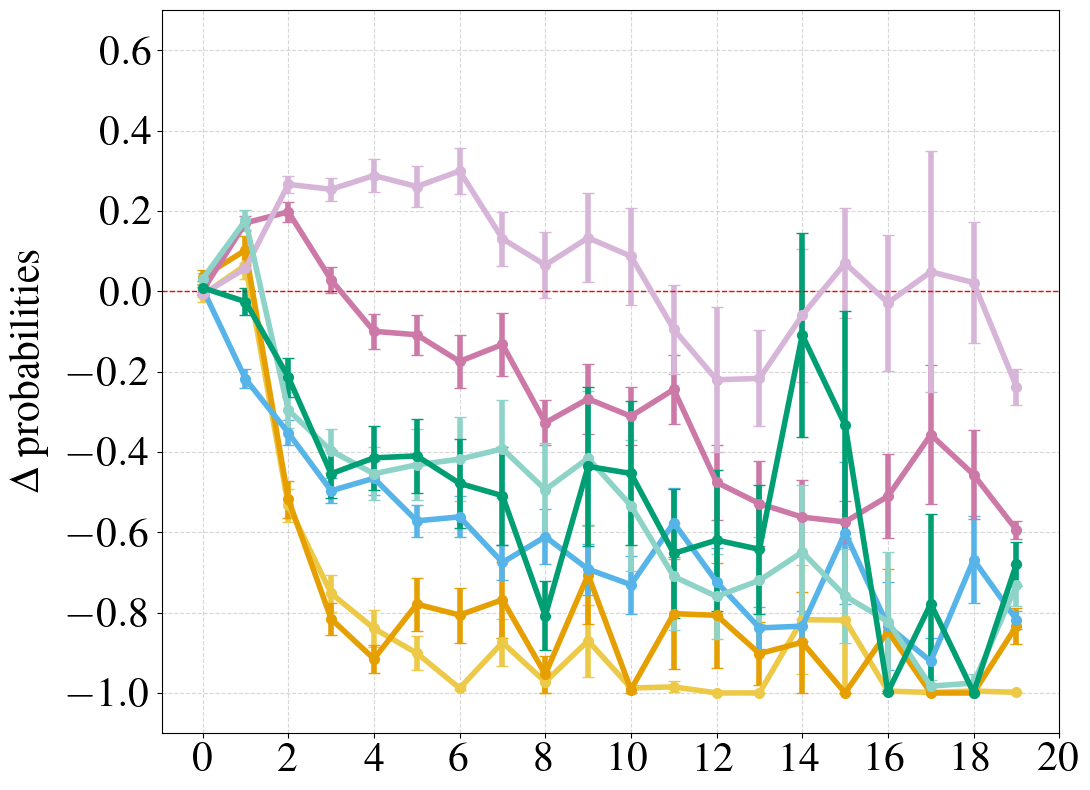

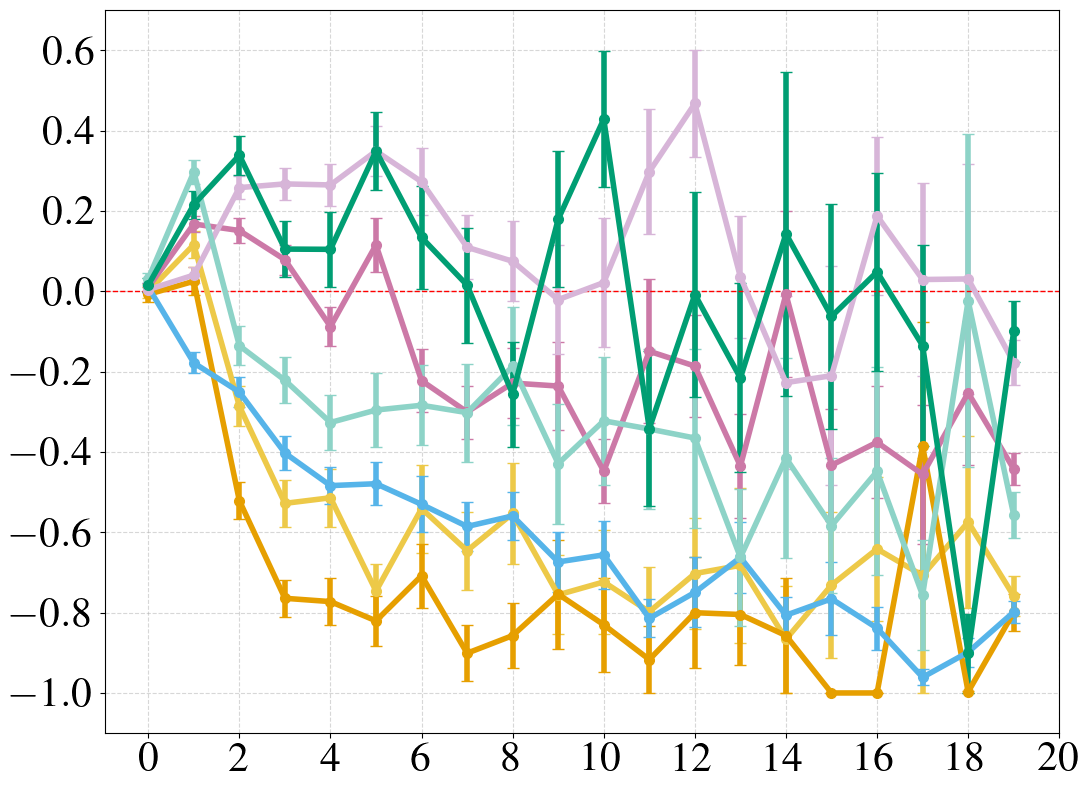

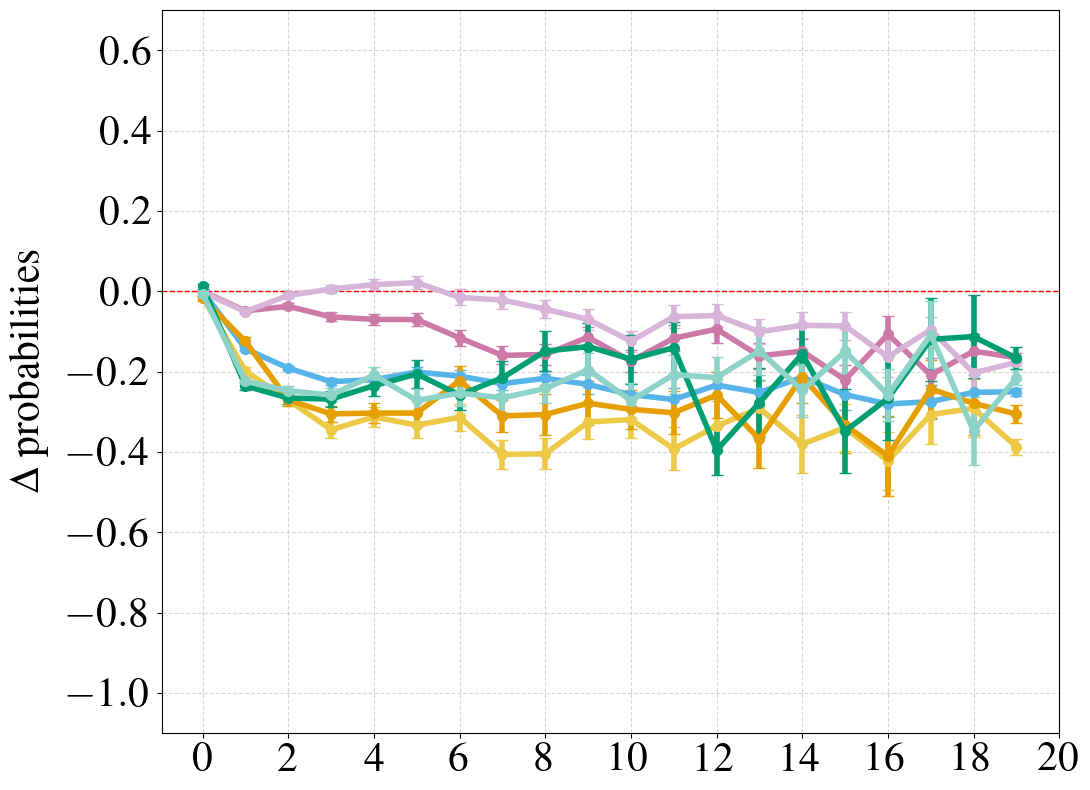

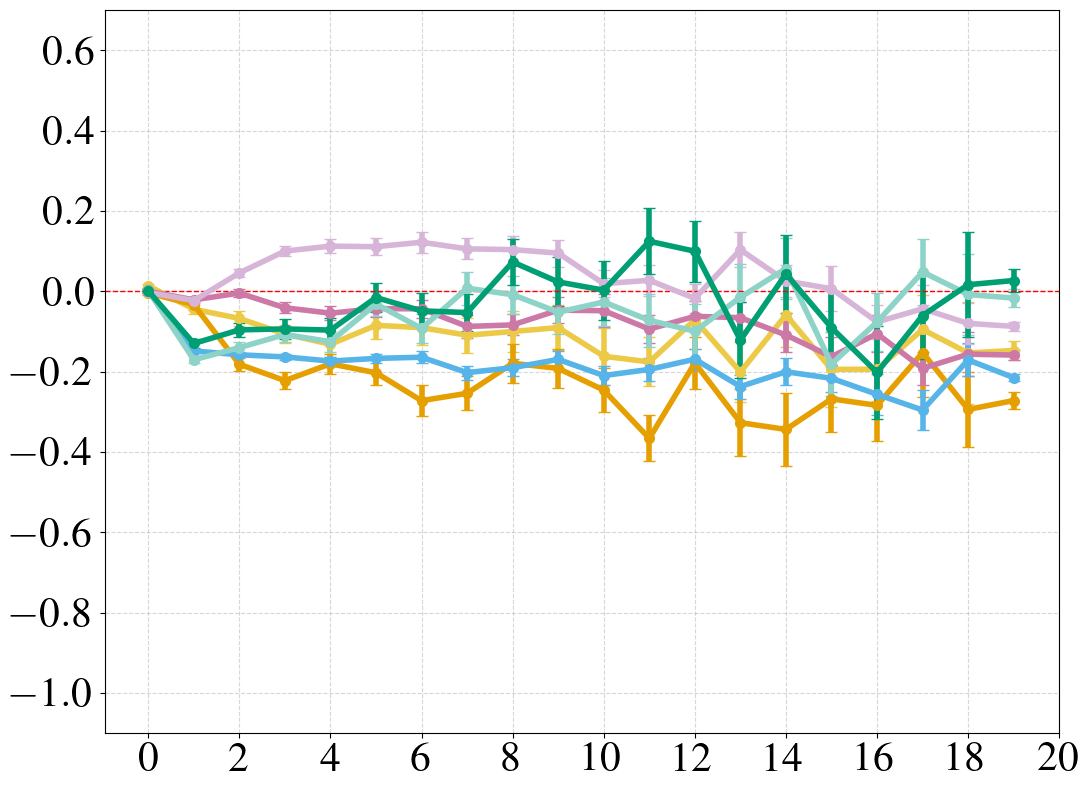

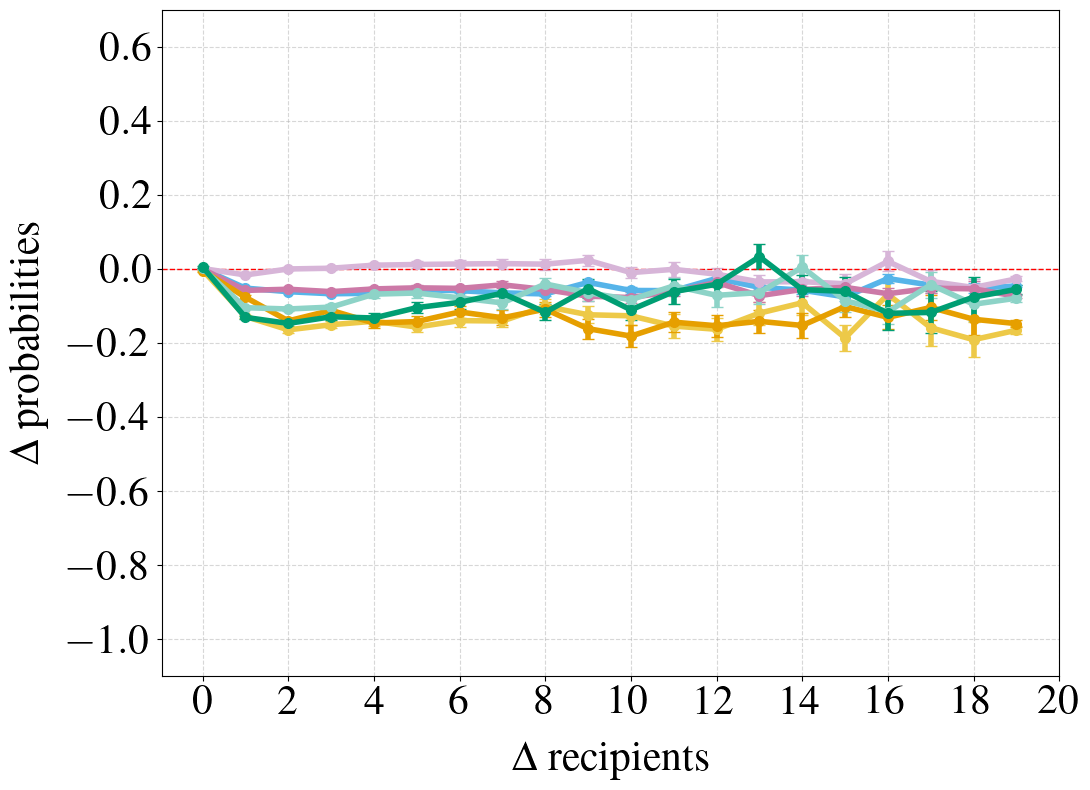

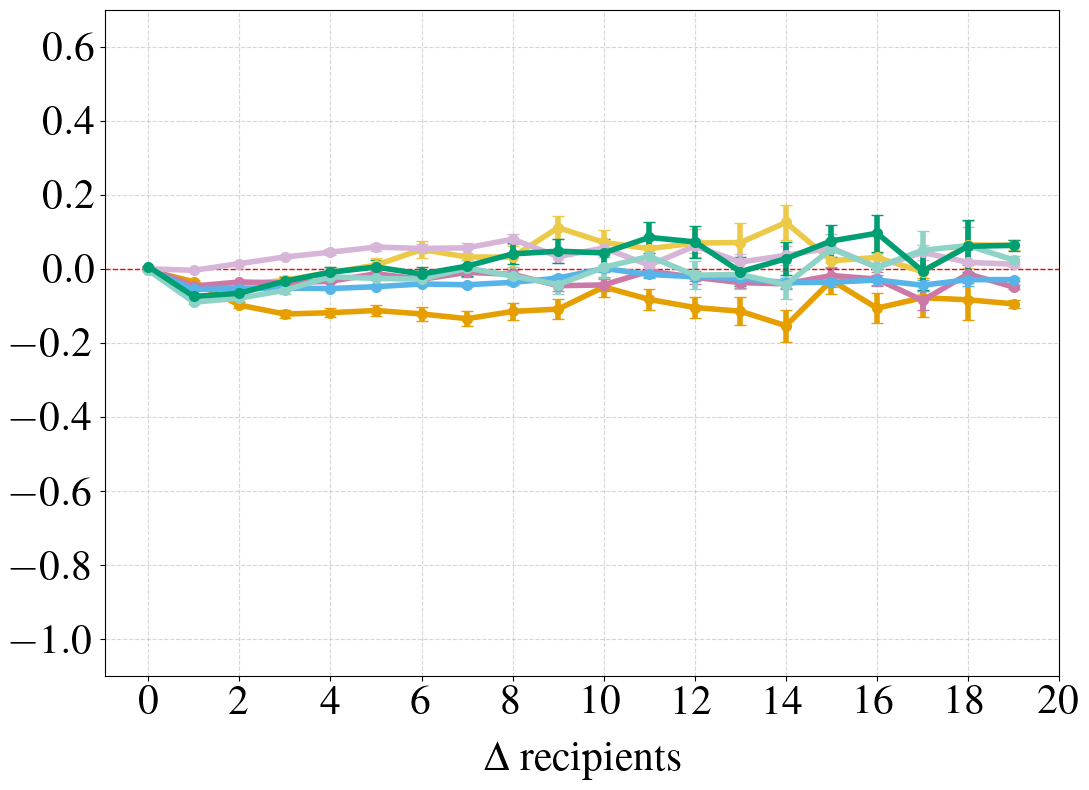

In [33]:
for n_mails, df_dict_u in dicts.items():
    
    for urgent, df_dict in df_dict_u.items():

        plot_onecond(df_dict, n_mails, family_colors, urgent)

### Statistical Analysis

In [15]:
def estimate_beta(df):
    # 1. Preprocessing
    df["log_byst"] = np.log(df["bystander"])
    
    # 2. Model Specification & Fitting
    formula = "prob ~ log_byst * urgency + pos"
    
    result = smf.ols(formula, df).fit(cov_type='cluster', 
                                      cov_kwds={'groups': df['trial']})
    print(result.summary())
    
    # 3. Extracting Parameters
    beta_b = result.params["log_byst"]
    se_b = result.bse["log_byst"]
    
    beta_int = result.params["log_byst:urgency"]
    se_int = result.bse["log_byst:urgency"]
    
    return beta_b, se_b, beta_int, se_int

In [20]:
def compare_model_coef(df_dict):
    
    rows = []
    
    for model_name, df in df_dict.items():
        print("------", model_name)
        beta_b, se_b, beta_int, se_int = estimate_beta(df)
        rows.append({
            "model": model_name,
            "beta byst": beta_b,
            "se byst": se_b,
            "ci_low byst": beta_b - 1.96 * se_b,
            "ci_high byst": beta_b + 1.96 * se_b,
            "beta int": beta_int,
            "se int": se_int,
            "ci_low int": beta_int - 1.96 * se_int,
            "ci_high int": beta_int + 1.96 * se_int
        })

    summary = pd.DataFrame(rows)

    # sort by defined model order
    summary["model"] = pd.Categorical(
        summary["model"], categories=model_order, ordered=True
    )
    summary = summary.sort_values("model")
    
    return summary

In [21]:
df_summary_2 = compare_model_coef(df_dict_2)

------ gemma12
                            OLS Regression Results                            
Dep. Variable:                   prob   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     1554.
Date:                Fri, 27 Feb 2026   Prob (F-statistic):               0.00
Time:                        15:04:32   Log-Likelihood:                -5338.7
No. Observations:               10000   AIC:                         1.069e+04
Df Residuals:                    9995   BIC:                         1.072e+04
Df Model:                           4                                         
Covariance Type:              cluster                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.34

In [22]:
df_summary_5 = compare_model_coef(df_dict_5)

------ llama8
                            OLS Regression Results                            
Dep. Variable:                   prob   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     3380.
Date:                Fri, 27 Feb 2026   Prob (F-statistic):               0.00
Time:                        15:04:45   Log-Likelihood:                 7133.0
No. Observations:               25000   AIC:                        -1.426e+04
Df Residuals:                   24995   BIC:                        -1.422e+04
Df Model:                           4                                         
Covariance Type:              cluster                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.100

In [23]:
df_summary_10 = compare_model_coef(df_dict_10)

------ gemma12
                            OLS Regression Results                            
Dep. Variable:                   prob   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     5440.
Date:                Fri, 27 Feb 2026   Prob (F-statistic):               0.00
Time:                        15:04:48   Log-Likelihood:                -3013.9
No. Observations:               50000   AIC:                             6038.
Df Residuals:                   49995   BIC:                             6082.
Df Model:                           4                                         
Covariance Type:              cluster                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.02

In [30]:
def plot_coefficients(df_summary, effect, num_mails):

    plt.figure(figsize=(9, 5))

    if effect == "bystander":
        plt.errorbar(
            df_summary["beta byst"],
            df_summary["model"],
            xerr=[
                df_summary["beta byst"] - df_summary["ci_low byst"],
                df_summary["ci_high byst"] - df_summary["beta byst"]
            ],
            fmt="o",
            capsize=7,
            color = "black",
            linewidth = 3,
            markersize = 8
        )
    if effect == "interaction":
        plt.errorbar(
            df_summary["beta int"],
            df_summary["model"],
            xerr=[
                df_summary["beta int"] - df_summary["ci_low int"],
                df_summary["ci_high int"] - df_summary["beta int"]
            ],
            fmt="o",
            capsize=7,
            color = "black",
            linewidth = 3,
            markersize = 8
        )
        

    plt.axvline(0, linestyle="--", c = "r")
    if num_mails == 10:
        plt.xlabel("Coefficient value", fontsize = 30, labelpad = 15)
    if effect == "bystander":
        plt.ylabel("Model", fontsize = 30, labelpad = 15)
    plt.yticks(fontsize = 30)
    plt.xticks(np.arange(-0.2, 0.11, 0.1), fontsize = 30)
    
    plt.tight_layout()
    loc = f"plots/advanced_choice/{effect}_coef_{num_mails}.pdf"
    plt.savefig(loc)
    plt.show()

Bystander 2


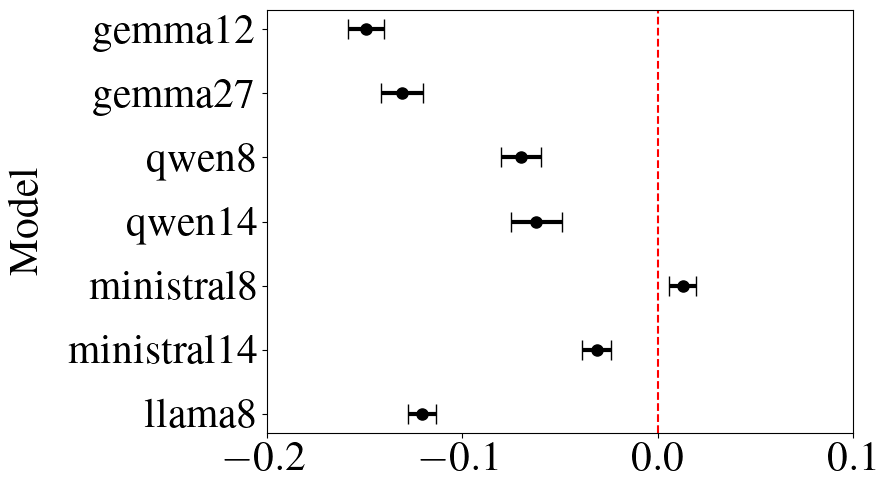

Interaction 2


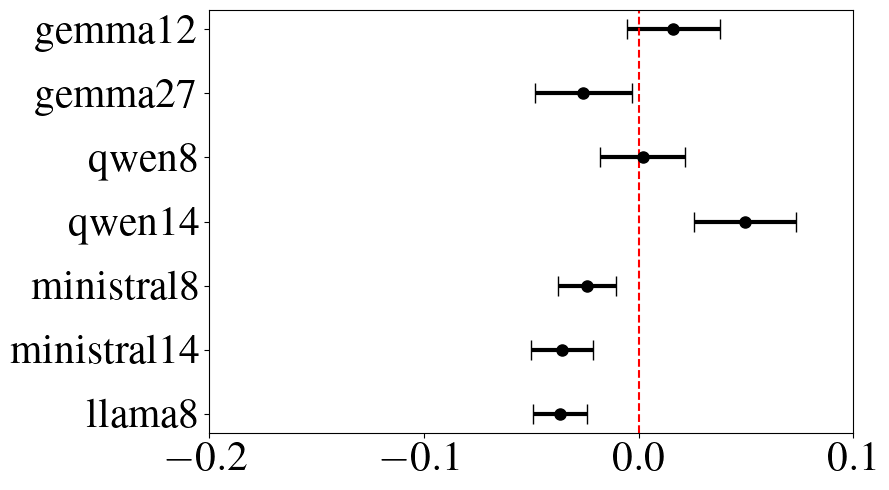

Bystander 5


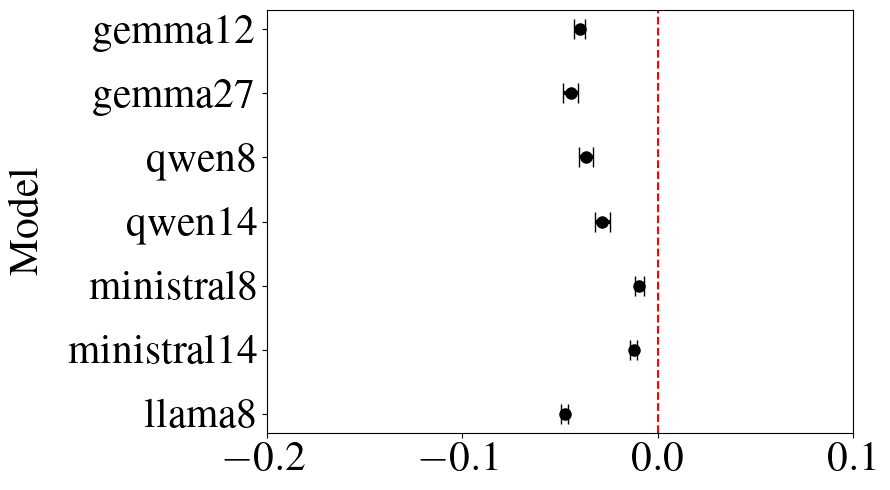

Interaction 5


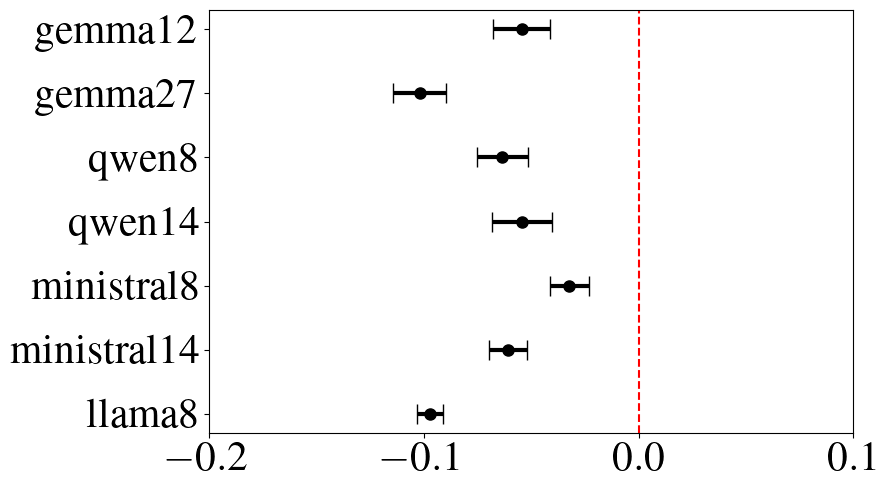

Bystander 10


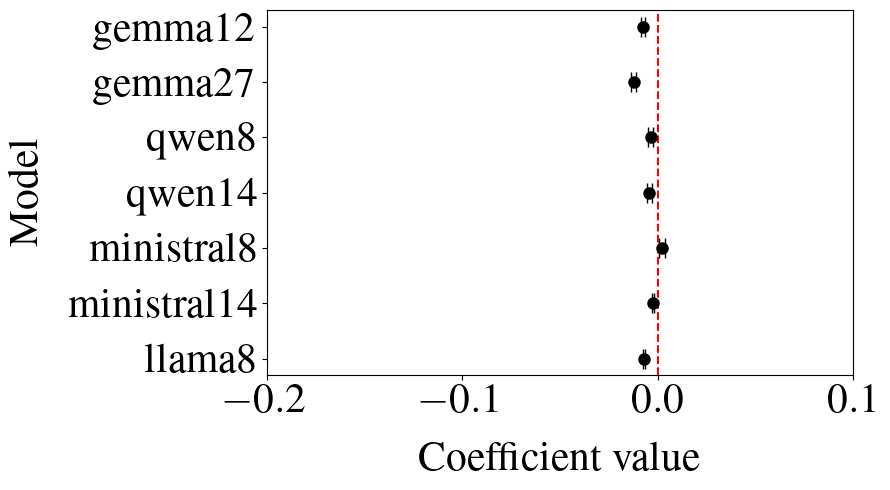

Interaction 10


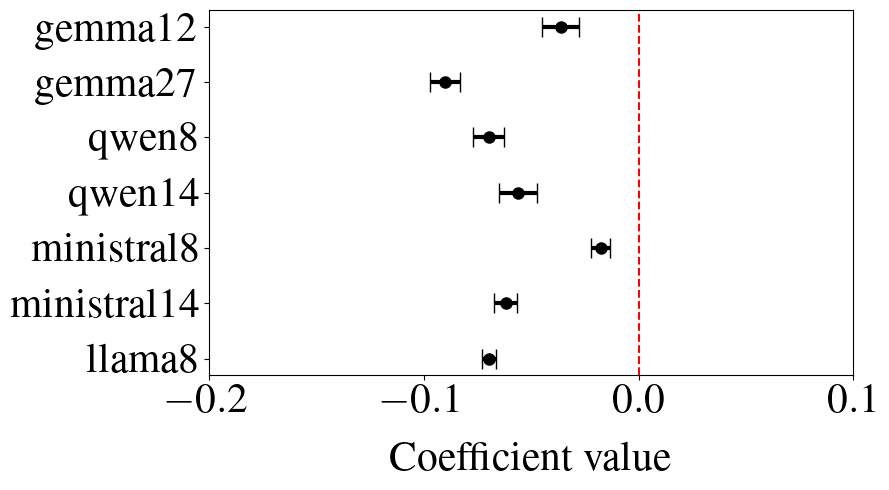

In [31]:
summary_dicts = {2: df_summary_2,
                5: df_summary_5,
                10: df_summary_10}

for n_mails, df_dict in summary_dicts.items():

    print("Bystander", n_mails)
    plot_coefficients(df_dict, "bystander", n_mails)
    print("Interaction", n_mails)
    plot_coefficients(df_dict, "interaction", n_mails)